In [1]:
!pip install tensorflow


In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt


In [3]:
img_size=256
btch_size=32
chanels=3
epoch=20
n_classes = 3

In [4]:
#load a dataset of images stored in a directory structure
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",#folder name where we have leaf img files
    labels='inferred',  # Automatically infer labels from subdirectory names
    label_mode='int',   # Return integer labels
    image_size=(img_size,img_size),
    batch_size=btch_size,
    shuffle=True,
    #seed=123,
    #validation_split=0.2,
    #subset='training'
)


Found 2152 files belonging to 3 classes.


In [5]:
#class_names gives the folders present in the directory
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for img_btch,label_btch in dataset.take(1):  #1 batch 32 imgs
    print(img_btch.shape)  
    #print(img_btch[0].shape) -->for one img
    print(label_btch.numpy())

(32, 256, 256, 3)
[0 0 1 1 0 0 1 0 0 2 1 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 0]


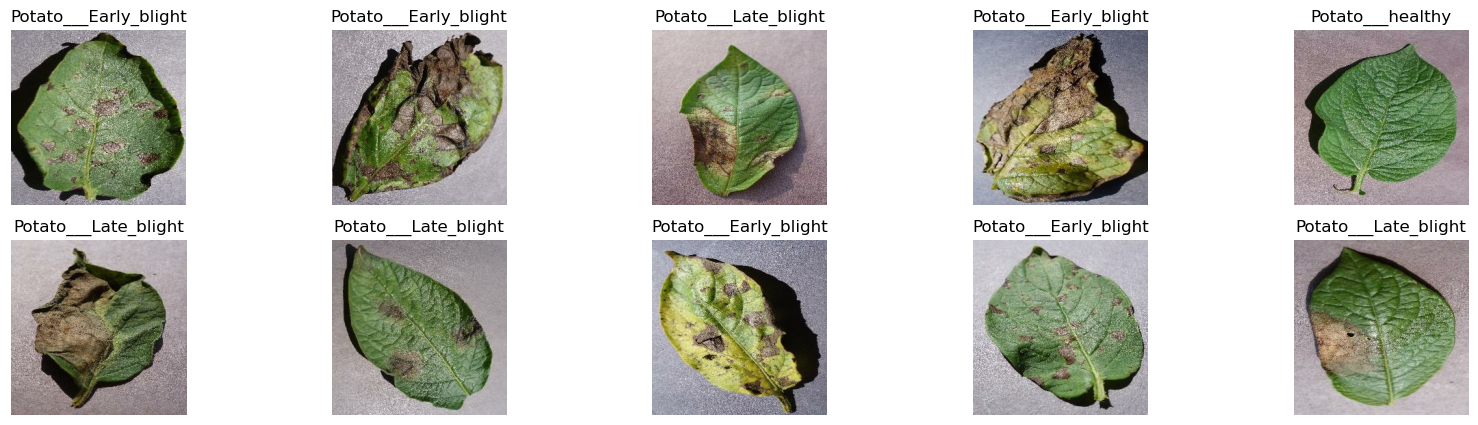

In [8]:
plt.figure(figsize=(20,5))
for img_btch,label_btch in dataset.take(1): 
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(img_btch[i].numpy().astype("uint8"))
        plt.title(class_names[label_btch[i]])
        plt.axis("off")

In [9]:
#splitting dataset into training and testing
#actual len=68*32  each ele is 32batch
#80%-->training
#20%-->10% validation & 10% testing

In [10]:
train_size=0.8
len(dataset)*train_size  #i.e we need 54 samples

54.400000000000006

In [11]:
train_ds=dataset.take(54)  #first 54
len(train_ds)

54

In [12]:
val_size=0.1
len(dataset)*val_size  #i.e we need 6 samples

6.800000000000001

In [13]:
test_ds=dataset.skip(54)
print(len(test_ds))

14


In [14]:
val_ds=test_ds.take(6)  #first 6 from the remaining  
print(len(val_ds))
# for test remainimg 6 so we use skip starting 6
test_ds=test_ds.skip(6)
print(len(test_ds))

6
8


In [15]:
def get_dataset_partitions_df(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
                          


In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_df(dataset)

In [17]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


In [18]:
#cache:
#for epoch 1 if a img is read and for epoch 2 if we need to read the same img
#tym taking process...so cache stores the img thus no need of reading repeatedly & saves tym
#prefetch:
#if GPU is not idle then CPU doesnt waste tym it loads the next batch 


In [19]:
train_ds=train_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(10000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(256,256),  #resizes if img is not (256,256)
    layers.Rescaling(1.0/255)      #divides or rescales all values by 256
])

In [21]:
#augmentation:
# for original img by applying filters or flips or contrast or rotation or zoom
#we can create new samples
#thus we can use the original + new samples for training --->so model is robust
# for example :
# if someone gives a rotated img our model can predit as we trained it by generating rotation ,flips..etc

In [22]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [23]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, chanels)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])



C:\Users\MANASWINI KARNATAKA\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.build(input_shape=(btch_size, img_size, img_size, chanels))

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history=model.fit(train_ds,epochs=epoch,batch_size=btch_size,verbose=1,validation_data=val_ds)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 764ms/step - accuracy: 0.4813 - loss: 0.9468 - val_accuracy: 0.6615 - val_loss: 0.7740
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 752ms/step - accuracy: 0.6771 - loss: 0.6737 - val_accuracy: 0.7812 - val_loss: 0.4704
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 725ms/step - accuracy: 0.7948 - loss: 0.4503 - val_accuracy: 0.9167 - val_loss: 0.2167
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 699ms/step - accuracy: 0.8773 - loss: 0.2836 - val_accuracy: 0.8802 - val_loss: 0.2961
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 727ms/step - accuracy: 0.8945 - loss: 0.2721 - val_accuracy: 0.9010 - val_loss: 0.2457
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 743ms/step - accuracy: 0.9034 - loss: 0.2249 - val_accuracy: 0.8698 - val_loss: 0.3221
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 703ms/step - accuracy: 0.9327 - loss: 0.1698 - val_accuracy: 0.8802 - val_loss: 0.2576
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 682ms/step - accuracy: 0.9510 - loss: 0.1403 - val_accu

In [27]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.9960 - loss: 0.0236


In [28]:
scores

[0.030724555253982544, 0.9921875]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

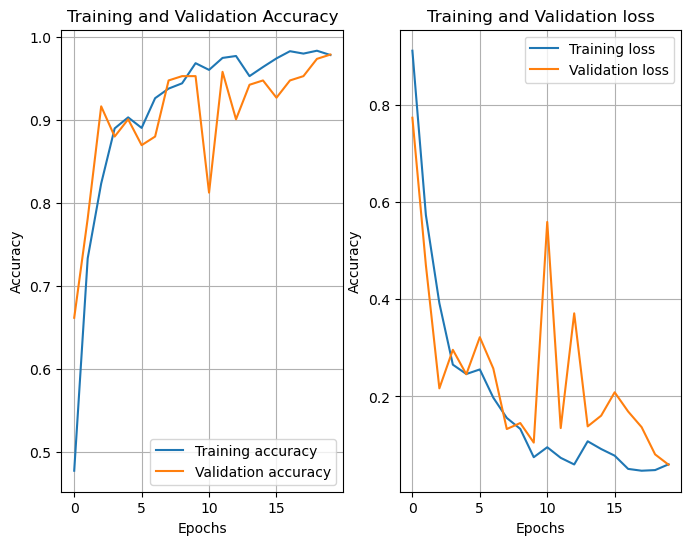

In [33]:
plt.figure(figsize=(8, 6))
plt.subplot(1,2,1)
plt.plot(range(epoch), acc, label='Training accuracy')
plt.plot(range(epoch), val_acc,label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(epoch), loss, label='Training loss')
plt.plot(range(epoch), val_loss,label='Validation loss')
plt.title('Training and Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [34]:
#plt.imshow(img_btch[0].numpy().astype('uint8'))

#print(img_btch[0].numpy().astype('uint8')) --->1st img
#print(img_btch[1].numpy().astype('uint8')) --->2nd img
# and so on........
    


first img to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
predicted label: Potato___Late_blight


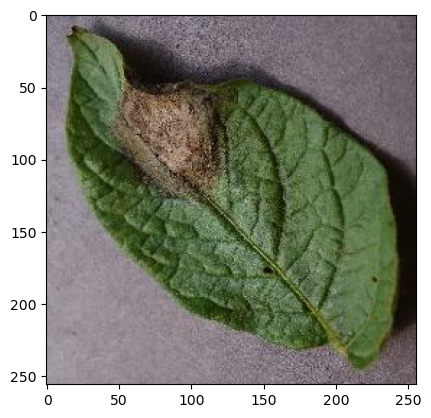

In [35]:
import numpy as np
for img_btch,label_btch in test_ds.take(1): 
    first_img=img_btch[0].numpy().astype('uint8')
    first_label=label_btch[0].numpy()
    
    print("first img to predict")
    plt.imshow(first_img)
    

    
        
    print("actual label:",class_names[first_label])    
    batch_prediction=model.predict(img_btch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])






In [36]:
#we get a 3D array because we gave 3 neurons activation func=softmax  
# softmax is probablity so we have 3 probs in array
#the highest prob is the actual class

#np.argmax([out prob array]) gives the highest prob index which is ntg but class label
#therefore we can use
# print(class_label[np.argmax(batch_prediction[0])])

In [37]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,axis=0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


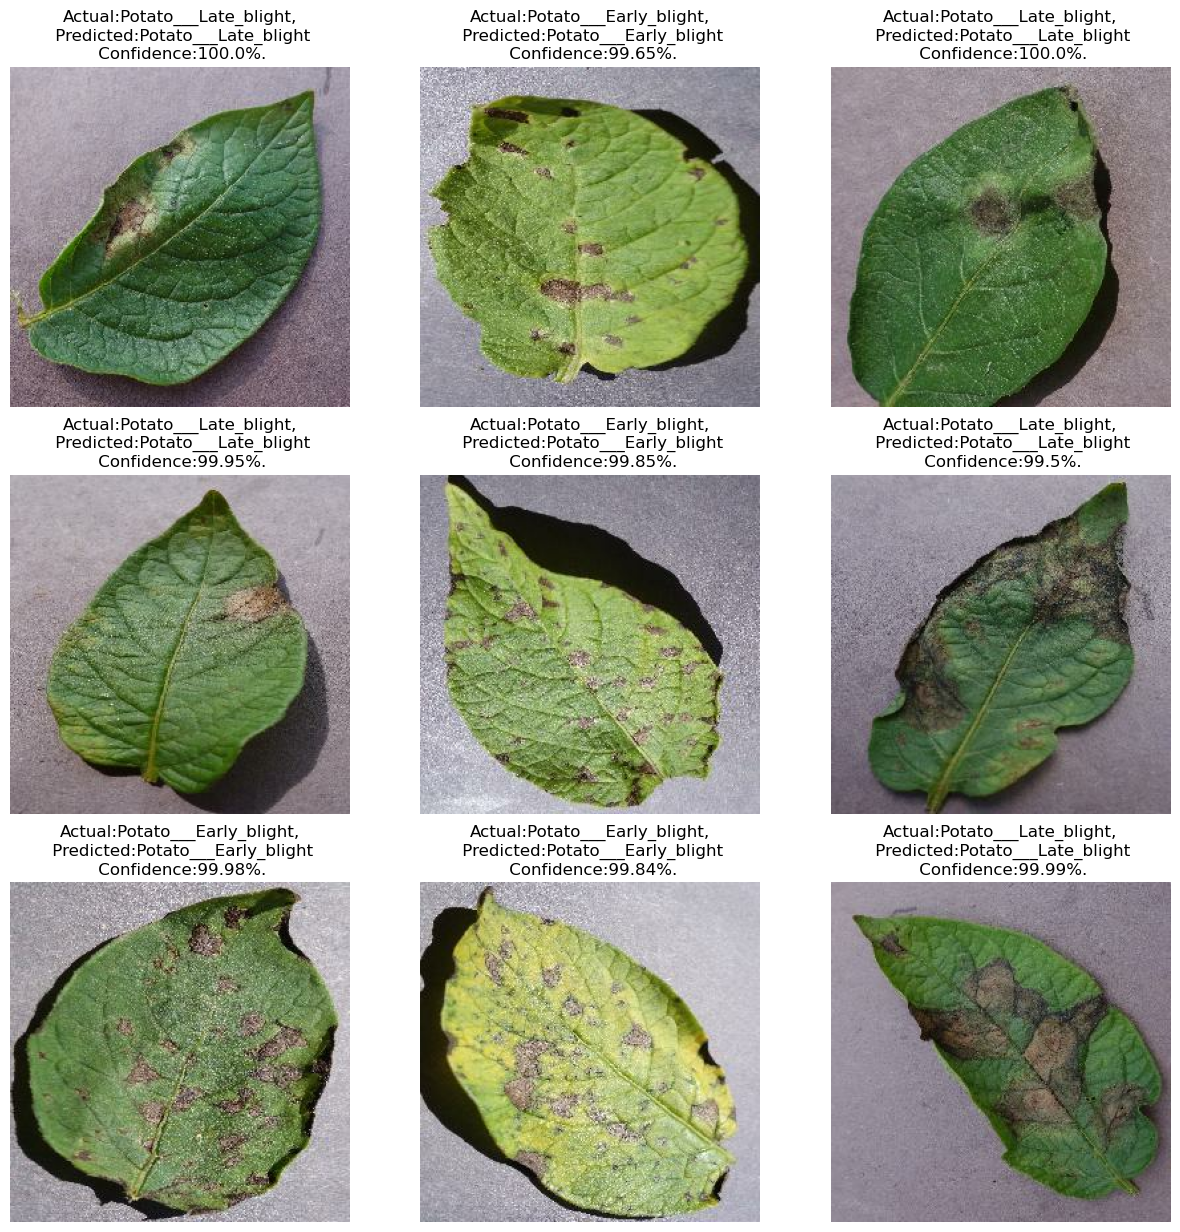

In [38]:
for images,labels in test_ds.take(1):
    plt.figure(figsize=(15,15))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}\n Confidence:{confidence}%.")
        plt.axis("off")          
    #plt.show()
       
                   
        

In [42]:
#import os
#model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
#model.save(f"../models/{model_version}")

#import os

# List all files in the directory
#files = os.listdir("../models")

# Filter out files that match the pattern (numeric without extension)
#model_versions = [int(f.split('.')[0]) for f in files if f.split('.')[0].isdigit()]

# If no numeric versions found, start with 0
#if not model_versions:
 #   model_versions = [0]

# Determine the next model version
#model_version = max(model_versions) + 1

# Save the model with a .keras extension
#model.save(f"../models/{model_version}.keras",save_format="keras")


#model.save("../potatoes.h5")

In [43]:
import os

# List all files in the directory
files = os.listdir("../models")

# Filter out files that match the pattern (numeric without extension)
model_versions = [int(f.split('.')[0]) for f in files if f.split('.')[0].isdigit()]

# If no numeric versions found, start with 0
if not model_versions:
    model_versions = [0]

# Determine the next model version
model_version = max(model_versions) + 1

# Save the model with a .keras extension
model.save(f"../models/{model_version}.keras")
